## Simple Linear Regression

Data source: 
- https://www.fao.org/markets-and-trade/commodities-overview/basic-foods/fao-dairy-price-index/en
- https://fred.stlouisfed.org/series/PWHEAMTUSDM

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
import pandas as pd
from sklearn.model_selection import train_test_split

from scipy.stats import pearsonr
from scipy.stats import kstest
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan

%matplotlib inline

import sys
sys.path.append(r'C:\Users\jeanb\Documents\Suisse\Job Search\Mondelez International\Market Analyst\Technical Interview Preparation Data')

### Data

In [11]:
#Read the data in the relevant Excel sheet
df = pd.read_excel(io='fao-dariy-price-indices-oct.xlsx', sheet_name='Dairy Price Index', skiprows=4) #data starts row 5
#Clean the data --> drop rows with NA values
df = df.dropna(axis='rows')
#Rename the columns
df.columns = ['Date', 'Dairy Price Index', 'Butter Index', 'SMP Index', 'WMP Index',
              'Cheese Index', 'Wheat Price', 'Corn Price', 'PPI Processed food from Cacao']
df.tail()

,Date,Dairy Price Index,Butter Index,SMP Index,WMP Index,Cheese Index,Wheat Price,Corn Price,PPI Processed food from Cacao
420,2025-02-01,147.687011,201.013020,106.679488,142.867800,147.531714,190.102642,221.254544,713.341
421,2025-03-01,148.736780,212.343462,108.283922,143.425443,146.081283,179.606542,207.751691,718.920
422,2025-04-01,151.721707,218.010960,110.135632,147.062778,148.495737,174.816743,215.569093,845.535
423,2025-05-01,153.626094,218.967925,110.161713,153.180885,149.698095,196.841071,204.808448,803.549
424,2025-06-01,155.504596,226.182527,109.856405,149.584970,152.751448,173.194763,195.719077,793.849


In [12]:
#We split the data into the one that will train the model (67%) and the one upon which the model will be tested upon (33%)
def split_data(data: pd.DataFrame):
    data = data.copy()

    X_train = data['Wheat Price']
    y_train = data['Dairy Price Index']
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

    return X_train, y_train

In [13]:
X_train, y_train = split_data(df)
X_train = X_train.values
y_train = y_train.values

#X_train = (X_train - np.mean(X_train)) / np.std(X_train)
#y_train = (y_train - np.mean(y_train)) / np.std(y_train)

#Visualizing the dataset
print("Type of x_train:",type(X_train))
print("First five elements of x_train are:\n", X_train[:5])
print("Type of y_train:",type(y_train))
print("First five elements of y_train are:\n", y_train[:5])  

Type of x_train: <class 'numpy.ndarray'>
First five elements of x_train are:
 [160.93727112 156.5280304  159.4675293  149.17929077 135.58413696]
Type of y_train: <class 'numpy.ndarray'>
First five elements of y_train are:
 [52.2186339  41.36712317 48.42706837 39.189651   39.189651  ]


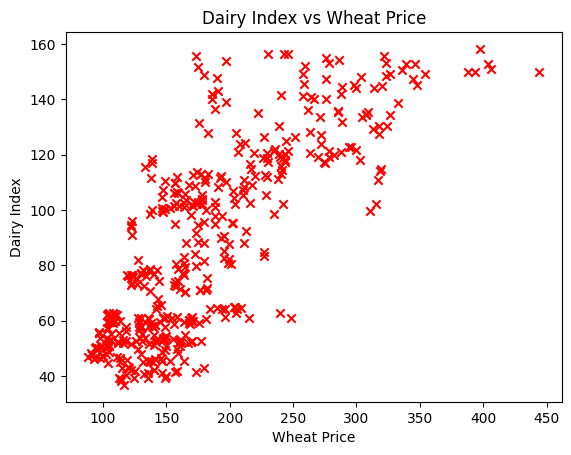

In [14]:
# Create a scatter plot of the data.
plt.scatter(X_train, y_train, marker='x', c='r') 

# Set the title
plt.title("Dairy Index vs Wheat Price")
# Set the y-axis label
plt.ylabel('Dairy Index')
# Set the x-axis label
plt.xlabel('Wheat Price')
plt.show()

### Assumptions

#### 1. Linearity

In [ ]:
#We check the linearity between y_train and each feature within X_train
corr_coef, p_value = pearsonr(X_train, y_train)

print(f"Pearson correlation coefficient: {corr_coef:.4f}")
print(f"P-value: {p_value:.4e}")

Pearson correlation coefficient: 0.7928
P-value: 5.5680e-93


As the Person correlation is superior to 0.7 and the p_value is inferior to 0.05, we reject the null hypothesis that there is no linearity.
Therefore, we assume that there is a linear relationship.

#### 2.Multivariate Normality

In [16]:
#Normalizing the data
X_mean = np.mean(X_train)
X_std = np.std(X_train)
y_mean = np.mean(y_train)
y_std = np.std(y_train)

X_train = (X_train - X_mean) / X_std
y_train = (y_train - y_mean) / y_std

In [21]:
#For X_train
ks_stat, p_value = kstest(X_train, 'norm')
print(f"For X_train, KS Statistic = {ks_stat:.4f}, p-value = {p_value:.4e}")

#For y_train
ks_stat, p_value = kstest(y_train, 'norm')
print(f"For y_train, KS Statistic = {ks_stat:.4f}, p-value = {p_value:.4e}")

For X_train, KS Statistic = 0.1275, p-value = 1.7683e-06
For y_train, KS Statistic = 0.1466, p-value = 1.9673e-08


As in both cases the p_value is inferior to 5%, we assume the normality of the data for X_train and y_train

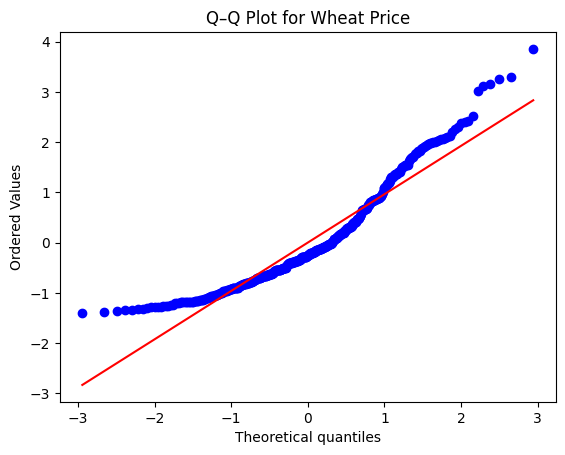

In [23]:
stats.probplot(X_train, dist="norm", plot=plt)
plt.title(f"Q–Q Plot for Wheat Price")
plt.show()

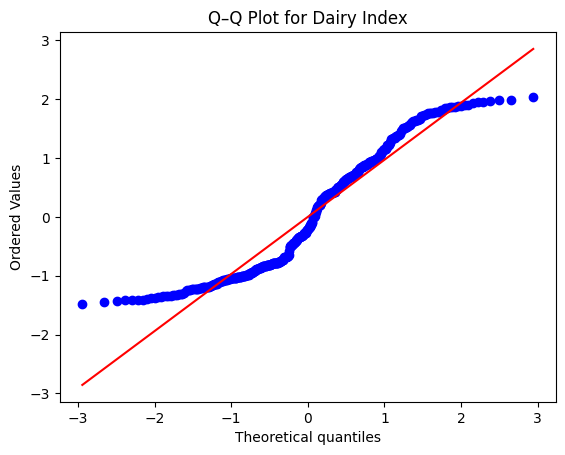

In [24]:
stats.probplot(y_train, dist="norm", plot=plt)
plt.title(f"Q–Q Plot for Dairy Index")
plt.show()

#### 3.Absence of Multicollinearity

Here, we don't have to do it as only one feature is present within X_train. Indeed, this test makes sure the features within X_train are not correlated.

#### 4. No Autocorrelation

In [27]:
#We apply the Durbin Watson Test to the residuals.

# Add constant (intercept)
X = sm.add_constant(X_train)

# Fit OLS regression
model = sm.OLS(y_train, X).fit()

# Compute residuals
residuals = model.resid
fitted_values = model.fittedvalues

In [28]:

# Durbin-Watson
dw = durbin_watson(residuals)
print(f"Durbin–Watson statistic: {dw:.3f}")

Durbin–Watson statistic: 0.091


Based on the Durbin-Watson test, we observe a high auto correlation between the Wheat Price and the Dairy Price Index. 

Indeed, there is no auto correlation if the value is around 2. 

In theory, for the linear regression to be truly effective, it should not have been the case. Maybe the DXY would have been a better choice, but for the sake of continuing this example, we will suppose that the auto correlation between X_train and y_train is acceptable.

#### 5. Homoscedasticity

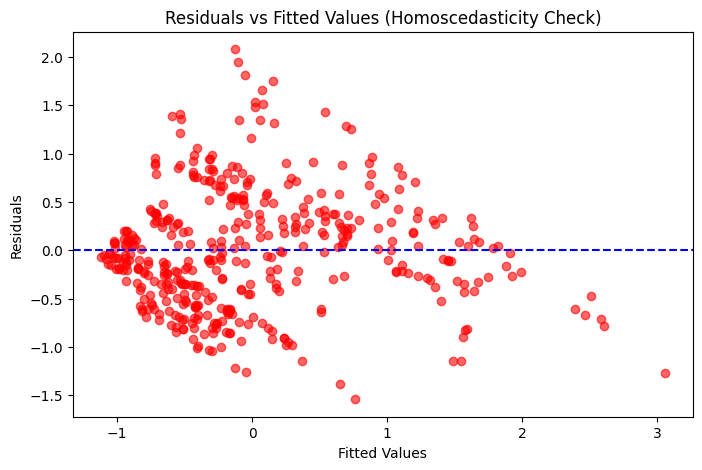

In [29]:
plt.figure(figsize=(8,5))
plt.scatter(fitted_values, residuals, color='red', alpha=0.6)
plt.axhline(y=0, color='blue', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Homoscedasticity Check)')
plt.show()

In [31]:
# Perform Breusch-Pagan test
bp_test = het_breuschpagan(residuals, model.model.exog)

# Extract results
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_results = dict(zip(labels, bp_test))

print("Breusch–Pagan test results:")
for k, v in bp_results.items():
    print(f"{k}: {v:.4f}")

Breusch–Pagan test results:
Lagrange multiplier statistic: 0.9627
p-value: 0.3265
f-value: 0.9603
f p-value: 0.3277


To check for homoscedasticity, two verifications are possible.
The first one is to check if the residuals look like noise, meaning no pattern is visible. Based on the graph, it is the case.

The second one is to use the Breush-Pagan test. 
If the p_value is superior to 5%, we cannot reject the null hypothesis, which that there is heteroscedasticity; meaning there is homoscedasticity.

### Cost computation and Gradient Descent

In [ ]:
def compute_cost(x, y, w, b): 
    """
    Computes the cost function for linear regression.
    """
    # number of training examples
    m = x.shape[0] 
    
    total_cost = 0

    cost=0
    for i in range(m):
        f_wb = w*x[i]+b
        cost += (f_wb - y[i])**2
    
    total_cost = cost/(2*m)
    

    return total_cost

In [ ]:
def compute_gradient(x, y, w, b): 
    """
    Computes the gradient for linear regression 
     """
    
    # Number of training examples
    m = x.shape[0]
    
    # You need to return the following variables correctly
    dj_dw = 0
    dj_db = 0
    
    for i in range(m):
        f_wb = w*x[i]+b
        dj_db += f_wb - y[i]
        dj_dw += (f_wb - y[i])*x[i]
    dj_dw /= m
    dj_db /= m
            
    return dj_dw, dj_db

In [ ]:
def gradient_descent(x, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    """
    
    # number of training examples
    m = len(x)
    
    # An array to store cost J and w's at each iteration — primarily for graphing later
    J_history = []
    w_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_dw, dj_db = gradient_function(x, y, w, b )  

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(x, y, w, b)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0:
            w_history.append(w)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
   

    return w, b, J_history, w_history #return w and J,w history for graphing

In [62]:
# initialize fitting parameters. Recall that the shape of w is (n,)
initial_w = 0.
initial_b = 0.

# some gradient descent settings
iterations = 1500
alpha = 0.01

w,b,_,_ = gradient_descent(X_train ,y_train, initial_w, initial_b, 
                     compute_cost, compute_gradient, alpha, iterations)
print("w,b found by gradient descent:", w, b)

Iteration    0: Cost     0.49   
Iteration  150: Cost     0.20   
Iteration  300: Cost     0.19   
Iteration  450: Cost     0.19   
Iteration  600: Cost     0.19   
Iteration  750: Cost     0.19   
Iteration  900: Cost     0.19   
Iteration 1050: Cost     0.19   
Iteration 1200: Cost     0.19   
Iteration 1350: Cost     0.19   
w,b found by gradient descent: 0.7927525710857893 -3.17811136884463e-17


In [63]:
m = X_train.shape[0]
predicted = np.zeros(m)

for i in range(m):
    predicted[i] = w * X_train[i] + b

In [64]:
#Revert Normalization
#X_train = X_train * X_std + X_mean
#predicted = predicted * y_std + y_mean

### Linear Regression Plotting

Text(0.5, 0, 'Wheat price')

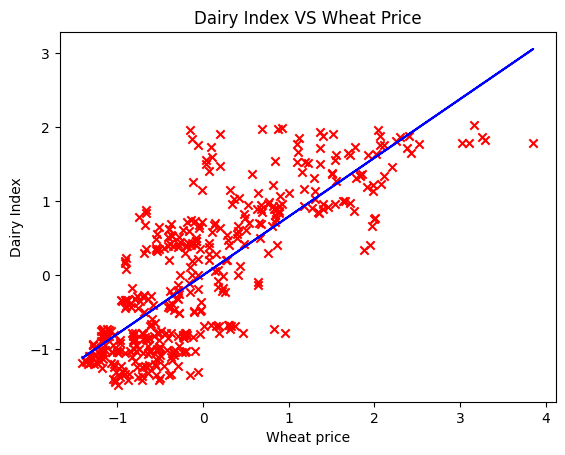

In [65]:
# Plot the linear fit
plt.plot(X_train, predicted, c = "b")

# Create a scatter plot of the data. 
plt.scatter(X_train, y_train, marker='x', c='r') 

# Set the title
plt.title("Dairy Index VS Wheat Price")
# Set the y-axis label
plt.ylabel('Dairy Index')
# Set the x-axis label
plt.xlabel('Wheat price')